In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import datasets
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
import cv2
import random
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import h5py
%matplotlib inline

In [3]:
from PIL import Image

In [4]:
data_dir = '/content/drive/MyDrive/Miniproject/chest_xray/Dataset'

In [5]:
import pathlib
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*/*')))
print(image_count)

5866


In [6]:
img = cv2.imread('/content/drive/MyDrive/Miniproject/chest_xray/Dataset/train/NORMAL/IM-0115-0001.jpeg')
img.shape

(1858, 2090, 3)

In [7]:
filepath = '/content/drive/MyDrive/Miniproject/chest_xray/Dataset/train/NORMAL/IM-0115-0001.jpeg'
img = tf.io.read_file(filepath)
img = tf.io.decode_jpeg(img, channels=1)
print(img.shape)
#print(tf.image.resize(img, [img_height, img_width]))


(1858, 2090, 1)


In [8]:
# Reading both normal and pneumonia files into a single object
train_ds_list = tf.data.Dataset.list_files(str(data_dir) +'/train/*/*', shuffle=True, seed = 0)
val_ds_list = tf.data.Dataset.list_files(str(data_dir) + '/val/*/*', shuffle= True, seed = 0)
test_ds_list = tf.data.Dataset.list_files(str(data_dir) + '/test/*/*', shuffle= True, seed = 0)

In [9]:
class_names = np.array(sorted(list(set([item.name for item in data_dir.glob('*/*') if item.name != "LICENSE.txt"]))))
print(class_names)

['NORMAL' 'PNEUMONIA']


In [10]:
img_height = 256
img_width = 256
batch_size = 32

In [11]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  #return tf.argmax(one_hot)
  return one_hot

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=1)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
  #label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img

# def label_path(file_path):
#   label = get_label(file_path)
#   return label

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds_list.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds_list.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds_list.map(process_path, num_parallel_calls=AUTOTUNE)

# train_class = train_ds_list.map(label_path, num_parallel_calls=AUTOTUNE)
# val_class = val_ds_list.map(label_path, num_parallel_calls=AUTOTUNE)
# test_class = test_ds_list.map(label_path, num_parallel_calls=AUTOTUNE)

In [12]:
rNr = tf.keras.Sequential([layers.Rescaling(1./255)]) #Rescaling
                           

In [13]:
def configure_for_performance(ds):
  ds = ds.batch(batch_size)
  ds = ds.map(lambda x : (rNr(x), rNr(x)), num_parallel_calls=AUTOTUNE)  
  ds = ds.cache()
  #ds = ds.shuffle(buffer_size=1000)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds


train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

### Model Training

In [14]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, BatchNormalization
from keras.models import Model

In [15]:
input_img = Input(shape=(img_height,img_width,1), name="m1_encoder_input")
x = Conv2D(256, (3, 3), (2, 2), activation='relu', padding ='same')(input_img)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), (2, 2), activation='relu', padding ='same')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), (2, 2), activation='relu', padding ='same')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Flatten()(x)
encoded = Dense(512, activation= 'relu')(x)

m1_encoder = Model(input_img, encoded, name="encoder_m1")

m1_encoder.summary()

Model: "encoder_m1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 m1_encoder_input (InputLaye  [(None, 256, 256, 1)]    0         
 r)                                                              
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 256)     2560      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 256)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 256)      1024      
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       295040    
                                                        

In [16]:
input_latent = Input(shape=(512), name="m1_decoder_input")
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(input_latent)
x = Reshape((32,32,1))(x)

x = Conv2D(64, (3, 3), activation='relu', padding ='same')(x)
x = UpSampling2D((2,2))(x)

x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding ='same')(x)
x = UpSampling2D((2,2))(x)

x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation='relu', padding ='same')(x)
x = UpSampling2D((2,2))(x)

x = BatchNormalization()(x)
decoded = Conv2D(1, (3, 3), activation='relu', padding ='same')(x)


m1_decoder = Model(input_latent, decoded, name="decoder_m1")

m1_decoder.summary()

Model: "decoder_m1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 m1_decoder_input (InputLaye  [(None, 512)]            0         
 r)                                                              
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 reshape (Reshape)           (None, 32, 32, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        640       
                                                                 
 up_sampling2d (UpSampling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 batch_normalization_4 (Batc  (None, 64, 64, 64)       2

In [17]:
# Autoencoder
ae_input = Input(shape=(img_height,img_width,1), name="m1_input")
ae_encoder_output = m1_encoder(ae_input)
ae_decoder_output = m1_decoder(ae_encoder_output)
m1 = tf.keras.models.Model(ae_input, ae_decoder_output, name="m1_output")
m1.summary()


Model: "m1_output"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 m1_input (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 encoder_m1 (Functional)     (None, 512)               897984    
                                                                 
 decoder_m1 (Functional)     (None, 256, 256, 1)       899073    
                                                                 
Total params: 1,797,057
Trainable params: 1,795,265
Non-trainable params: 1,792
_________________________________________________________________


In [18]:
# Delta compressing autoencoder
#Encoder


In [19]:
# CUSTOM_loss
def customLoss(y_true, y_pred):
    mse = tf.keras.backend.mean(tf.keras.backend.square(y_true-y_pred))
    msssim_loss = 1 - tf.reduce_mean(tf.image.ssim_multiscale(y_true, y_pred, 1.0))
    custom = mse*0.5 + msssim_loss*0.5
    return custom

#def a custom IoU

def customIoU(y_true, y_pred):
    nonzero_off = 1e-5
    y_true_f = tf.keras.backend.flatten(y_true[:,:,:,0])
    y_pred_f = tf.keras.backend.flatten(y_pred[:,:,:,0])
    #Compute intersection score in flattened vectors by dot mul
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f*y_true_f) + tf.keras.backend.sum(y_pred_f*y_pred_f) - intersection 
    iou = intersection/(union + nonzero_off)
    return iou

# AE Compilation
m1.compile(loss=customLoss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[customIoU, tf.keras.metrics.KLDivergence(),tf.keras.metrics.MeanSquaredError()]) #learning_rate=0.0005 , metrics = [MSSSIMLoss, 'accuracy']

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

wtpath="/content/drive/MyDrive/Miniproject/chest_xray/CNN2/weights/weights_best_fast.hdf5"
checkpoint = ModelCheckpoint(wtpath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=5,mode='min')
callbacks_list = [checkpoint,es]

In [ ]:
# Training AE
hist = m1.fit(train_ds, 
       epochs=50, 
       batch_size=batch_size, 
       #shuffle=True, 
       validation_data = val_ds,
       callbacks=callbacks_list)

Epoch 1/50
133/133 [==============================] - ETA: 0s - loss: 0.3815 - customIoU: 0.3547 - kullback_leibler_divergence: 1.4733 - mean_squared_error: 0.1757
Epoch 1: val_loss improved from inf to 0.34346, saving model to /content/drive/MyDrive/Miniproject/chest_xray/CNN2/weights/weights_best_fast.hdf5
133/133 [==============================] - 232s 2s/step - loss: 0.3815 - customIoU: 0.3547 - kullback_leibler_divergence: 1.4733 - mean_squared_error: 0.1757 - val_loss: 0.3435 - val_customIoU: 0.3721 - val_kullback_leibler_divergence: 0.0128 - val_mean_squared_error: 0.0499
Epoch 2/50
133/133 [==============================] - ETA: 0s - loss: 0.1882 - customIoU: 0.3932 - kullback_leibler_divergence: 0.4743 - mean_squared_error: 0.0250
Epoch 2: val_loss improved from 0.34346 to 0.31060, saving model to /content/drive/MyDrive/Miniproject/chest_xray/CNN2/weights/weights_best_fast.hdf5
133/133 [==============================] - 113s 849ms/step - loss: 0.1882 - customIoU: 0.3932 - kull

In [ ]:
m1.save('/content/drive/MyDrive/Miniproject/chest_xray/CNN2/weights/model_last_fast.hdf5')  # creates a HDF5 file 'my_model.h5'

In [21]:
### Load pretrained model to see IoU score
from keras.models import load_model
m1test = load_model("/content/drive/MyDrive/Miniproject/chest_xray/CNN2/weights/weights_best_fast.hdf5", compile=False)
m1test.compile(metrics=[customIoU])  #NO loss metric given to compile
m1test.evaluate(test_ds)                                                #CNN 2.0 MODEL LOADED  

20/20 [==============================] - 454s 22s/step - loss: 0.0000e+00 - customIoU: 0.9686


[0.0, 0.9686052203178406]

In [20]:
from keras.models import load_model
m1test = load_model("/content/drive/MyDrive/Miniproject/chest_xray/CNN/weights/weights_best_fast.hdf5", compile=False)
m1test.compile(metrics=[customIoU])  #NO loss metric given to compile
m1test.evaluate(test_ds)                # CNN 1.0 MODEL LOADED

20/20 [==============================] - 212s 10s/step - loss: 0.0000e+00 - customIoU: 0.9640


[0.0, 0.9640449285507202]

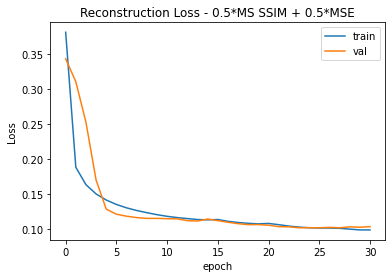

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Reconstruction Loss - 0.5*MS SSIM + 0.5*MSE')
plt.ylabel('Loss')
plt.autoscale()
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.savefig('/content/drive/MyDrive/Miniproject/chest_xray/CNN2/msssim.jpg')
plt.show()

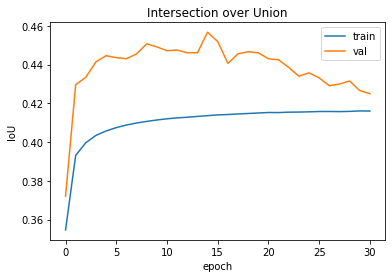

In [ ]:
plt.plot(hist.history['customIoU'])
plt.plot(hist.history['val_customIoU'])
plt.title('Intersection over Union')
plt.ylabel('IoU')
#plt.ylim(top=0.02,bottom = 0.001)
plt.autoscale()
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.savefig('/content/drive/MyDrive/Miniproject/chest_xray/CNN2/iou.jpg')
plt.show()

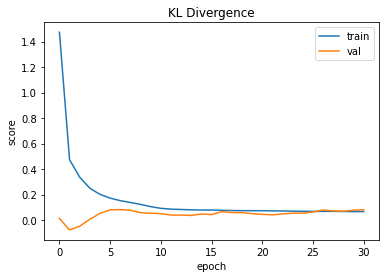

In [ ]:
plt.plot(hist.history['kullback_leibler_divergence'])
plt.plot(hist.history['val_kullback_leibler_divergence'])
plt.title('KL Divergence')
plt.ylabel('score')
plt.autoscale()
#plt.ylim(top=0.02,bottom = 0.001)
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.savefig('/content/drive/MyDrive/Miniproject/chest_xray/CNN2/kld.jpg')
plt.show()

In [ ]:
m1.evaluate(test_ds)

20/20 [==============================] - 60s 3s/step - loss: 0.1129 - customIoU: 0.3989 - kullback_leibler_divergence: 0.1082 - mean_squared_error: 0.0084


[0.11294679343700409,
 0.39894938468933105,
 0.10821952670812607,
 0.008387135341763496]

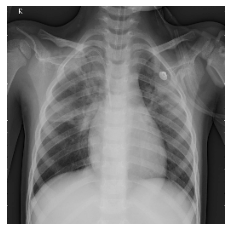

In [ ]:
for batch in test_ds.take(1):
    #print(image[0].shape)
    image = batch[0][0]
    plt.imshow(image.numpy().reshape(256,256),'gray')
    plt.axis('off')
    plt.savefig('/content/drive/MyDrive/Miniproject/chest_xray/CNN2/True.png')

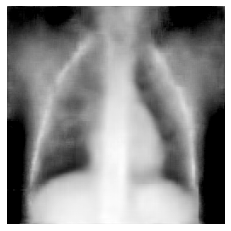

In [ ]:
pred_ds = m1.predict(test_ds)
rec = pred_ds[0]
plt.imshow(rec.reshape(256,256),'gray')
plt.axis('off')
plt.savefig('/content/drive/MyDrive/Miniproject/chest_xray/CNN2/Reconstruction.png')

In [ ]:
diff = image - rec
np.mean(np.square(diff.numpy()))

0.006653551

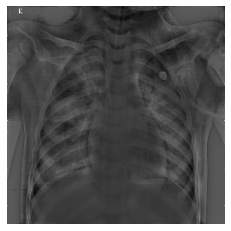

In [ ]:
diff = image - rec
np.mean(np.square(diff.numpy()))
plt.imshow(diff.numpy().reshape(256,256),'gray')
plt.axis('off')
plt.savefig('/content/drive/MyDrive/Miniproject/chest_xray/CNN2/Delta.png')

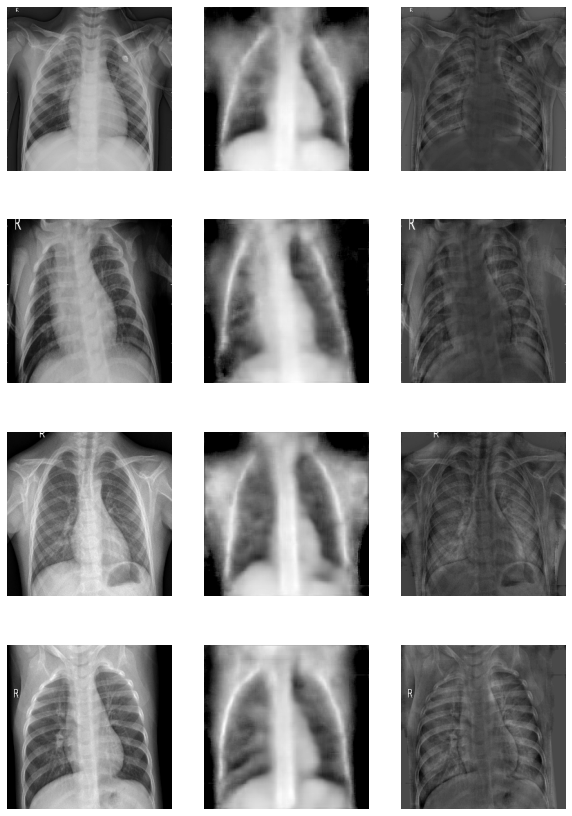

In [ ]:
plt.figure(figsize=(10,15)) 
num_images_to_show = 4
for im_ind in range(num_images_to_show):
    plot_ind = im_ind*3 + 1
    #rand_ind = np.random.randint(low=0, high=x_train.shape[0])
    plt.subplot(num_images_to_show, 3, plot_ind)
    for batch in test_ds.take(1):
        image = batch[0][im_ind]
        plt.imshow(image.numpy().reshape(256,256),'gray')
        plt.axis('off')
    rec = pred_ds[im_ind]
    plt.subplot(num_images_to_show, 3, plot_ind+1)
    plt.imshow(rec.reshape(256,256),'gray')
    plt.axis('off')
    plt.subplot(num_images_to_show, 3, plot_ind+2)
    diff = image - rec
    plt.imshow(diff.numpy().reshape(256,256),'gray')
    plt.axis('off')
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.5, 
#                     top=0.2, 
#                     wspace=0.5, 
#                     hspace=0.5)
plt.savefig('/content/drive/MyDrive/Miniproject/chest_xray/CNN2/summary.png')

In [ ]:
np.save('/content/drive/MyDrive/Miniproject/chest_xray/CNN2/deltac.npy',diff)